In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

plt.rcParams["figure.figsize"] = (10,5)

1. Задание.
    - Для реализованной в методичке модели градиентного бустинга построить зависимости ошибки от количества деревьев при разных значениях шага градиента на одном графике и для разной глубины деревьев на другом. 
    - Сделать выводы о зависимости ошибки от этих гиперпараметров (шаг градиента, максимальная глубина деревьев, количество деревьев). 
    - Подобрать оптимальные значения этих гиперпараметров (минимум ошибки на тесте при отсутствии переобучения).

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    """предсказание с помощью градиентного бустинга"""
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании 
    # прибавляются с шагом eta
    return np.array([sum([
        eta * coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) 
                     for x in X])

In [6]:
def mean_squared_error(y_real, prediction):
    """среднеквадратичная ошибка"""
    return (sum((y_real - prediction) ** 2)) / len(y_real)

In [7]:
def bias(y, z):
    """смещение для L2-loss"""
    return - 2 * (z - y)

In [8]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    """обучение градиентного бустинга"""
    
    # eta - скорость обучения
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            z_train = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы, начиная со второго, обучаем на сдвиг
            tree.fit(X_train, bias(y_train, z_train))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [9]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    """ошибка алгоритма на тренировочной и тестовой выборках"""
    
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из\t{n_trees} деревьев\tглубиной {max_depth}'
          f'\tс шагом {eta}\tна тренировочной выборке:\t{round(mean_squared_error(y_train, train_prediction))}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из\t{n_trees} деревьев\tглубиной {max_depth}'
          f'\tс шагом {eta}\tна   тестовой    выборке:\t{round(mean_squared_error(y_test, test_prediction))}')

In [10]:
errors = {
    'train': {'ETA': {}, 'MAX_DEPTH': {} },
    'test': {'ETA': {}, 'MAX_DEPTH': {} },
}

In [11]:
n_trees = 10
coefs = [1] * n_trees  # для простоты примем коэффициенты равными 1
max_depth = 3
for eta in (0.5, 0.05, 0.005):
    trees, errors['train']['ETA'][eta], errors['test']['ETA'][eta] = \
    gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.5	на тренировочной выборке:	1095.0
Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.5	на   тестовой    выборке:	4845.0
Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.05	на тренировочной выборке:	6281.0
Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.05	на   тестовой    выборке:	5836.0
Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.005	на тренировочной выборке:	25184.0
Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.005	на   тестовой    выборке:	22519.0


In [12]:
n_trees = 10
coefs = [1] * n_trees  # для простоты примем коэффициенты равными 1
eta = 0.5
for max_depth in (2, 3, 5, 7):
    trees, errors['train']['MAX_DEPTH'][max_depth], errors['test']['MAX_DEPTH'][max_depth] = \
    gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из	10 деревьев	глубиной 2	с шагом 0.5	на тренировочной выборке:	1916.0
Ошибка алгоритма из	10 деревьев	глубиной 2	с шагом 0.5	на   тестовой    выборке:	3731.0
Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.5	на тренировочной выборке:	1095.0
Ошибка алгоритма из	10 деревьев	глубиной 3	с шагом 0.5	на   тестовой    выборке:	4845.0
Ошибка алгоритма из	10 деревьев	глубиной 5	с шагом 0.5	на тренировочной выборке:	144.0
Ошибка алгоритма из	10 деревьев	глубиной 5	с шагом 0.5	на   тестовой    выборке:	5928.0
Ошибка алгоритма из	10 деревьев	глубиной 7	с шагом 0.5	на тренировочной выборке:	3.0
Ошибка алгоритма из	10 деревьев	глубиной 7	с шагом 0.5	на   тестовой    выборке:	4974.0


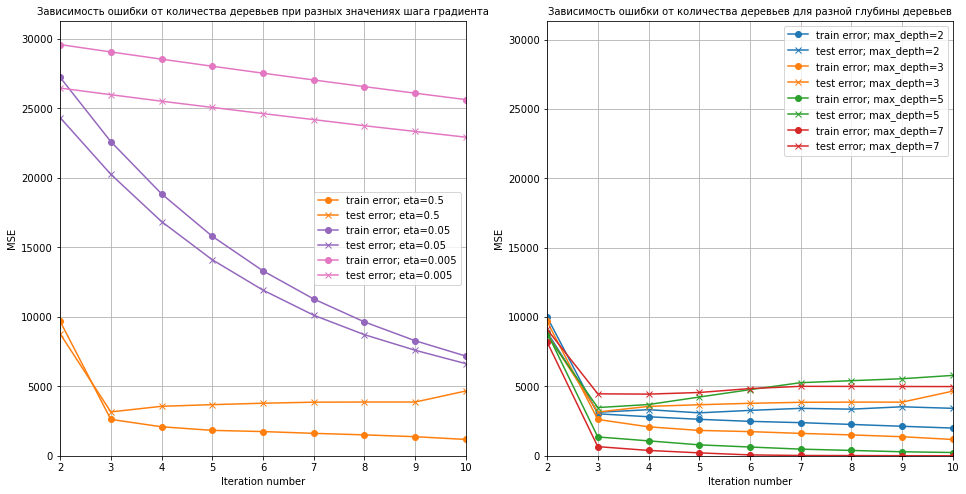

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

x = list(range(1, n_trees+1))

ax1.set_title('Зависимость ошибки от количества деревьев при разных значениях шага градиента', fontsize=10)
N = 1
for eta in errors['train']['ETA'].keys():
    ax1.plot(x, errors['train']['ETA'][eta], f'C{N}', marker='o', label=f'train error; {eta=}')
    ax1.plot(x, errors['test']['ETA'][eta], f'C{N}', marker='x', label=f'test error; {eta=}')
    N *= 4

ax2.set_title('Зависимость ошибки от количества деревьев для разной глубины деревьев', fontsize=10)
N = 0
for max_depth in errors['train']['MAX_DEPTH'].keys():
    ax2.plot(x, errors['train']['MAX_DEPTH'][max_depth], f'C{N}', marker='o', label=f'train error; {max_depth=}')
    ax2.plot(x, errors['test']['MAX_DEPTH'][max_depth], f'C{N}', marker='x', label=f'test error; {max_depth=}')
    N += 1
    
for ax in (ax1, ax2):
    ax.set_xlabel('Iteration number')
    ax.set_ylabel('MSE')
    ax.set_xlim(2, n_trees)
    ax.set_ylim(bottom=0)
    # ax.set_yscale("log")
    ax.grid()
    ax.legend();

2. (\*) Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5.    Сравнить на одном графике кривые  изменения ошибки на тестовой выборке в зависимости от  числа итераций.

3. (\*) Модифицировать алгоритм градиентного бустинга, взяв за основу реализацию решающего дерева из ДЗ_4 (для задачи регрессии). Сделать выводы о качестве алгоритма по сравнению с реализацией из п.1.